# Installation

In [ ]:
!pip3.9 install requests pandas scikit-learn matplotlib

# Imports

In [36]:
from datetime import timedelta, date, datetime as dt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


# Feature Generation

In [37]:
years = [2020, 2021, 2022]
data = pd.DataFrame()
for year in years:
    df = pd.read_csv(f'{year}.csv') 
    data = pd.concat([data, df], ignore_index=True)


In [38]:
data = data.drop(['Number of People', "Activity"], axis=1)
data.describe()


,Time Spent (seconds),Productivity
count,150678.000000,150678.000000
mean,190.438027,0.481158
std,444.081977,1.378553
min,1.000000,-2.000000
25%,7.000000,0.000000
50%,30.000000,1.000000
75%,133.000000,2.000000
max,3600.000000,2.000000


In [39]:
# Change productivity values to a value between -1 and 1
data['Productivity'] = np.where(data['Productivity'] >= 1, 1, data['Productivity'])

# Change values less than or equal to -1 to -1
data['Productivity'] = np.where(data['Productivity'] <= -1, -1, data['Productivity'])


In [40]:
data['Productivity'] = data['Time Spent (seconds)'] * data['Productivity']
data["Date"] = pd.to_datetime(data['Date'])
grouped_data = data.groupby('Date').agg({
    'Productivity': 'sum'
}).reset_index()
grouped_data
data = grouped_data

In [41]:
# Change productivity values to a value between -1 and 1
data['Productivity'] = np.where(data['Productivity'] >= 1, 1, data['Productivity'])

# Change values less than or equal to -1 to -1
data['Productivity'] = np.where(data['Productivity'] <= -1, -1, data['Productivity'])


In [42]:
all_timestamps_df = pd.DataFrame(pd.date_range(start='2022-01-01', end='2022-12-31', freq='H'), columns=['Date'])

all_timestamps_df['Productivity'] = 0

merged_df = pd.merge(all_timestamps_df, data, on='Date', how='left')

merged_df['Productivity'] = merged_df['Productivity_x'].where(merged_df['Productivity_y'].isna(), merged_df['Productivity_y'])

# Drop the unnecessary columns
merged_df = merged_df.drop(['Productivity_x', 'Productivity_y'], axis=1)

data = merged_df

In [43]:
data['is_weekend'] = data['Date'].dt.weekday >= 5
data['hour'] = data['Date'].dt.hour
data['day_of_week'] = data['Date'].dt.dayofweek  # 0 is Monday, 6 is Sunday
data['month'] = data['Date'].dt.month
data['day_of_month'] = data['Date'].dt.day
data['year'] = data['Date'].dt.year
data['is_work_hours'] = ((data['hour'] >= 8) & (data['hour'] <= 16) & (data['day_of_week'] <= 5))
data

,Date,Productivity,is_weekend,hour,day_of_week,month,day_of_month,year,is_work_hours
0,2022-01-01 00:00:00,0,True,0,5,1,1,2022,False
1,2022-01-01 01:00:00,0,True,1,5,1,1,2022,False
2,2022-01-01 02:00:00,0,True,2,5,1,1,2022,False
3,2022-01-01 03:00:00,0,True,3,5,1,1,2022,False
4,2022-01-01 04:00:00,0,True,4,5,1,1,2022,False
...,...,...,...,...,...,...,...,...,...
8732,2022-12-30 20:00:00,-1,False,20,4,12,30,2022,False
8733,2022-12-30 21:00:00,1,False,21,4,12,30,2022,False
8734,2022-12-30 22:00:00,-1,False,22,4,12,30,2022,False
8735,2022-12-30 23:00:00,0,False,23,4,12,30,2022,False


In [44]:
data['is_work_hours'] = ((data['hour'] >= 8) & (data['hour'] <= 16) & (data['day_of_week'] <= 5))
data['is_weekend'] = data['is_weekend'].astype(int)
data['is_work_hours'] = data['is_work_hours'].astype(int)

# Model Creation

In [45]:
X = data[["is_weekend", "hour", "day_of_week", "month", "day_of_month", "is_work_hours"]]
y= data["Productivity"]
data.dtypes

Date             datetime64[ns]
Productivity              int64
is_weekend                int64
hour                      int32
day_of_week               int32
month                     int32
day_of_month              int32
year                      int32
is_work_hours             int64
dtype: object

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [47]:
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [48]:
predictions = model.predict(X_test)
print(predictions[:])
print(y_test.values[:])


[0 0 1 ... 0 0 0]
[-1  0 -1 ...  0  0  0]


In [49]:
accuracy = accuracy_score(y_test.values, predictions)
accuracy

0.700228832951945

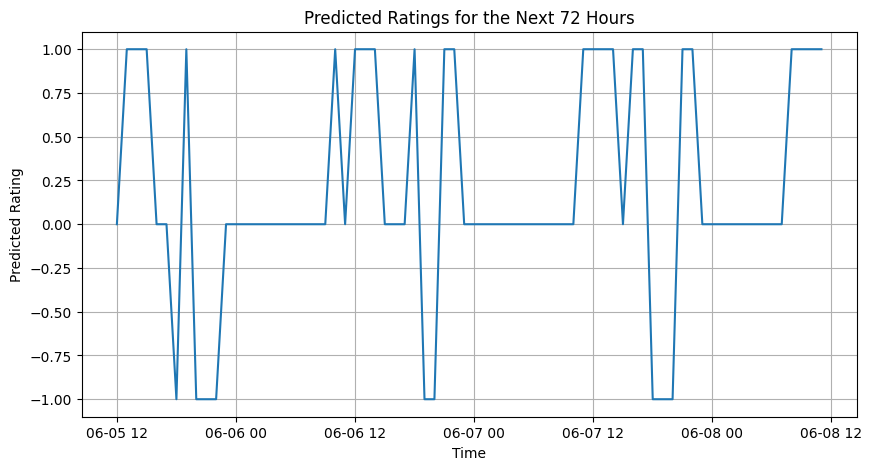

In [51]:
predictions = []

# Get the current timestamp
timestamp = dt.strptime("June 5, 2023 12pm", "%B %d, %Y %I%p")
timestampList = []

# Generate data points for every hour for the next 72 hours
for i in range(72):
    # Create a DataFrame with the extracted features
    data_point = pd.DataFrame({
        'is_weekend': [1 if timestamp.weekday() >= 5 else 0],
        'hour': [timestamp.hour],
        'day_of_week': [timestamp.weekday() + 1],  # +1 to make Monday=1, Sunday=7
        'month': [timestamp.month],
        'day_of_month': [timestamp.day],
        'is_work_hours': [1 if 8 <= timestamp.hour < 16 else 0]
    })

    # Use the model to make a prediction and store it in the list
    prediction = model.predict(data_point)
    predictions.append(prediction[0])
    timestampList.append(timestamp)
    # Increment the timestamp by one hour
    timestamp += timedelta(hours=1)

# Generate a sequence of timestamps for the next 72 hours
timestamps = pd.date_range("June 5, 2023 12pm", periods=72, freq='H')

# Plot the predictions
plt.figure(figsize=(10, 5))
plt.plot(timestamps, predictions)
plt.xlabel('Time')
plt.ylabel('Predicted Rating')
plt.title('Predicted Ratings for the Next 72 Hours')
plt.grid(True)
plt.show()